# Chapter 4: Split-Apply-Combine and Merging 

```{contents} Table of Contents
:depth: 3
```

## Split - Apply - Combine

A common task in statistical programming is to apply the same function to many groups of observations and return the results. 
Because individual outcomes/observations correspond to rows in a dataframe, we often need an additional column (or variable) that identifies which row belongs to which group. 
This additional column is almost always some set of fixed possibilities. 

--- 

*Example Australian Doctor visits :* 
The [dataset](https://vincentarelbundock.github.io/Rdatasets/doc/AER/DoctorVisits.html) that we will explore is a cross section of information about Australian doctor visits between the years 1977 and 1978. The reported 5,190 observations correspond to patients treated within this decade and the columns refer to information like the number of visits to a physician in the past two weeks (visits), age in years divided by 100 (age), the annual income of the patient in tens of thousands, etc. 

---

In [2]:
import pandas as pd
import numpy as np 

doctorVisits = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/AER/DoctorVisits.csv")
doctorVisits

,rownames,visits,gender,age,income,illness,reduced,health,private,freepoor,freerepat,nchronic,lchronic
0,1,1,female,0.19,0.55,1,4,1,yes,no,no,no,no
1,2,1,female,0.19,0.45,1,2,1,yes,no,no,no,no
2,3,1,male,0.19,0.90,3,0,0,no,no,no,no,no
3,4,1,male,0.19,0.15,1,0,0,no,no,no,no,no
4,5,1,male,0.19,0.45,2,5,1,no,no,no,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5185,5186,0,female,0.22,0.55,0,0,0,no,no,no,no,no
5186,5187,0,male,0.27,1.30,0,0,1,no,no,no,no,no
5187,5188,0,female,0.37,0.25,1,0,1,no,no,yes,no,no
5188,5189,0,female,0.52,0.65,0,0,0,no,no,no,no,no


We can see that there exist specific column that can group together rows. 
For example, the variable ```private``` has values "yes" and "no" that correspond to whether the patient does or does not have private health insurance. 
This means that we can split pour dataframe into those who have private insurance and those who do not. 

In [3]:
private_insurance    = doctorVisits.loc[doctorVisits.private   =="yes"]
no_private_insurance = doctorVisits.loc[doctorVisits["private"]=="no"]

**Note:** the two different ways to refer to a variable above. 
We have discussed before that you can refer to a variable using square brackets and the name of the variable enclosed in quotes. 
However, when a dataframe is created every column name is added as an attribute. 
That means we can refer to the column ```private``` using either ```doctorVisits["private"]``` or ```doctorVisits.private```. 

Now that our observations have been split into groups, we may want to apply a function that computes the mean and standard deviation of the number of visits. 
We will create a function called ```summarize_visits``` that inputs a dataframe and outputs a dictionary with those two summary metrics. 

In [4]:
def summarize_visits(d,label):
    import numpy as np 
    mean_visits = np.mean(d.visits)
    sd_visits   = np.std(d.visits)
    return pd.Series({"group": label,  "mean_visits": mean_visits, "sd_visits":sd_visits})

#--lets apply the above function to both data frames above
summary__private    = summarize_visits(private_insurance   ,"yes")
summary__no_private = summarize_visits(no_private_insurance,"no")

Lets look at one of these Series to get a feel for what they look like. 

In [5]:
summary__private

group               yes
mean_visits    0.294604
sd_visits      0.771995
dtype: object

The final step would be to combine our results from the different groups. 

In [6]:
combine = pd.DataFrame([summary__private, summary__no_private])
combine

,group,mean_visits,sd_visits
0,yes,0.294604,0.771995
1,no,0.307400,0.818130


### Groupby as a (much easier) implementation of the Split-Apply-Combine paradigm

The above procedure has been used so many times that computer scientists decided to optimize this process.
The code to implement the procedure is easier and will compute faster than if we implemented the above three steps. 
For Python, we use **groupby**. 

Given a dataframe, $\mathcal{F}$, **Groupby** takes two inputs: (1) a list of column names for how to define a group. 
For a list of column names $[c_{1},c_{2},\cdots,c_{n}]$, define the set of unique values in column $c_{1}$ as $C_{1}$, the unique values in $c_{2}$ as $C_{2}$, etc. 
Then a group is an element of $C_{1} \times C_{2} \times \cdots \times C_{n}$.
Where $A \times B = \{ (x,y): x \in A \text{ and } y \in B \}$ is called the Cartesian product of $A$ and $B$. 

Input (2) is a function to apply to each group.
This function should input a dataframe and return any Python object.

Lets try to use thie groupby technique to return the mean and standard deviation of the number of visist, stratified by private insurance. 

In [7]:
def summarize_visits(d):
    import numpy as np 
    mean_visits = np.mean(d.visits)
    sd_visits   = np.std(d.visits)
    return pd.Series({"mean_visits": mean_visits, "sd_visits":sd_visits})

doctorVisits.groupby(["private"]).apply( summarize_visits,include_groups=False )

,mean_visits,sd_visits
private,,
no,0.307400,0.818130
yes,0.294604,0.771995


## Merging

WHen you want to combine two or more datasets this is called merging. 
There are several types of merges, but they all rely on the same process. 
Given a dataset $D_{1}$ and a second dataset $D_{2}$, we want to combine them into a dataset $D$ such that 
1. The same observation in $D_{1}$ is matched with $D_{2}$
2. The columns in $D_{1}$ are retained and the columns in $D_{2}$ are retained. 

The two most common types of merges are 1-1 merging and 1-manymerging. 

## 1-1 merging

A 1-1 merge assumes that there is the same, unique observation present in both $D_{1}$ and $D_{2}$.
For our example we'll use a, non-health, but instructive, database called [MovieLens](https://grouplens.org/datasets/movielens/).

The MovieLens database contains four datasets: movies, links, ratings, and tags.
Lets look at the movies and links datasets. 

In [8]:
import pandas as pd
movies = pd.read_csv("./ml-32m/movies.csv")
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),Comedy|Drama
87582,292753,Orca (2023),Drama
87583,292755,The Angry Breed (1968),Drama


In [9]:
links  = pd.read_csv("./ml-32m/links.csv")
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
87580,292731,26812510,1032473.0
87581,292737,14907358,986674.0
87582,292753,12388280,948139.0
87583,292755,64027,182776.0


Suppose that we want to "add in " the columns from the links dataset with the movies dataset. 
That is, the experiment here is the production of a move and a single "observation" in this experiment is one movie. 

Pandas has a command called `merge` that can combine these datasets.
To merge, we will need to provide dataset one, dataset two, and the columns that are used in both datasets to identify on, unique observation. 

In [10]:
#d1----------d2-----how to define a unique obs
movies.merge(links  , on = ["movieId"]        )

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0
...,...,...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama,26812510,1032473.0
87581,292737,Shelter in Solitude (2023),Comedy|Drama,14907358,986674.0
87582,292753,Orca (2023),Drama,12388280,948139.0
87583,292755,The Angry Breed (1968),Drama,64027,182776.0


We can see that our merge produced a new, combined, dataset: one with all the columns in `movies` plus all the columns in `links`. **Important:** it is crucial to check that the number of rows in the original and final datasets match what you would expect. Here we expected that there would exist a match in each dataset. What happens if that isnt the case? 

## Matching (inner, left, right)
Lets remove all but 600 movies from the links dataset and see what happens when we merge this time. 

In [11]:
import numpy  as np 
pick_600_rows = np.random.choice( len(links), 600 ) #<-- seleect 600 rows at random
_600_links = links.iloc[ pick_600_rows ]            #<--use iloc to pick 600

In [12]:
movies.merge(_600_links  , on = ["movieId"]        )

,movieId,title,genres,imdbId,tmdbId
0,320,Suture (1993),Film-Noir|Thriller,108260,87078.0
1,350,"Client, The (1994)",Drama|Mystery|Thriller,109446,10731.0
2,413,Airheads (1994),Comedy,109068,13595.0
3,493,Menace II Society (1993),Action|Crime|Drama,107554,9516.0
4,498,Mr. Jones (1993),Drama|Romance,107611,2625.0
...,...,...,...,...,...
595,290401,NYC Point Gods (2022),Documentary,20805164,997638.0
596,290832,Lifemark (2022),Drama,20864704,975407.0
597,291058,A Lesson Of Love (2014),(no genres listed),1791441,336113.0
598,291100,Pudsey the Dog: The Movie (2014),Adventure|Children|Comedy,3171246,283237.0


What happened? Even though the movies dataset had 87,585 movies, only 600 appear in our merge!
Where are our movies? 
The default behavior for merge is to run what is called an "inner merge".

An inner merge looks at the unique observations in $D_{1}$, finds those observations that match in $D_{2}$ and the nonly returns those observations that appear in **both** datasets. 

### Left Merge

A "left" merge will keep all observations from $D_{1}$ and add-in matching observations from $D_{2}$.
Columns from $D_{2}$ will be combined with columns in $D_{1}$. 
If there is no matching observation in $D_{2}$ then the columns that correspond to $D_{2}$ will be filled with the value ```nan```. 

An example is useful to illustrate the impact of a left merge.
To run a left merge in Python we use the same merge command and add the keyword ```how="left"```.

In [17]:
left_merged_movies = movies.merge(_600_links  , on = ["movieId"], how = "left"        )
left_merged_movies.iloc[315:325]

,movieId,title,genres,imdbId,tmdbId
315,319,Shallow Grave (1994),Comedy|Drama|Thriller,NaN,NaN
316,320,Suture (1993),Film-Noir|Thriller,108260.0,87078.0
317,321,Strawberry and Chocolate (Fresa y chocolate) (...,Drama,NaN,NaN
318,322,Swimming with Sharks (1995),Comedy|Drama,NaN,NaN
319,324,"Sum of Us, The (1994)",Comedy|Drama,NaN,NaN
320,325,National Lampoon's Senior Trip (1995),Comedy,NaN,NaN
321,326,To Live (Huozhe) (1994),Drama,NaN,NaN
322,327,Tank Girl (1995),Action|Comedy|Sci-Fi,NaN,NaN
323,328,Tales from the Crypt Presents: Demon Knight (1...,Horror|Thriller,NaN,NaN
324,329,Star Trek: Generations (1994),Adventure|Drama|Sci-Fi,NaN,NaN


In the above merge, $D_{1}$ contains all of the observations with movie ids 319,320,...329. 
However, the dataset $D_{2}$ only contains the observation corresponding to movie id 320. 
Since there is a match for movie id 320 the columns in $D_{2}$ (imdbId	tmdbId) are combined with $D_{1}$.
Since, for example, there is no movie id 319 in $D_{2}$ the columns imdbId	tmdbId are filled with ```nan```.

### Right merge
A right merge behaves exactly the same as a left merge with on exception.
The second dataset in the merge ($D_{2}$) is the dataset that contains all observations and any observatins in $D_{1}$ that match $D_{2}$ will be added to $D_{2}$.

In [19]:
right_merged_movies = movies.merge(_600_links  , on = ["movieId"], how = "right"        )
right_merged_movies.iloc[315:325]

,movieId,title,genres,imdbId,tmdbId
315,129508,Violent Playground (1958),Drama,52367,93181.0
316,146024,A Man from Boulevard des Capucines (1987),Comedy|Romance|Western,92745,45227.0
317,118512,Bring It On: In It To Win It (2007),Comedy,972785,15261.0
318,162914,On tour (1990),Comedy,100699,58773.0
319,249408,Contribution (2016),Mystery,4842282,393074.0
320,222669,Fly-By-Night (1942),Drama|Thriller,34740,25634.0
321,148482,Truth (2015),Drama,3859076,300693.0
322,187717,Won't You Be My Neighbor? (2018),Documentary,7681902,490003.0
323,194540,K - Shop (2016),Crime|Horror|Thriller,3221544,403820.0
324,213051,Se mieletön remppa (2020),Comedy,10449466,649719.0


## In class excercise and exploration

In [63]:
covid= pd.read_csv("https://data.cdc.gov/resource/pwn4-m3yp.csv?$limit=500000")

#--NOT NEEDED FOR LESSON---------------------------------
def from_day_to_closest_saturday(x):
    from datetime import datetime, timedelta
    day =  datetime.strptime(x.split("T")[0], "%Y-%m-%d")
    while day.weekday()!=5:
        day = day + timedelta(days=1)
    return day.strftime("%Y-%m-%d")
end_of_weeks = [from_day_to_closest_saturday(x) for x in covid.end_date]

covid["end_of_weeks"] = end_of_weeks
#------------------------------------------------------------

flu = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

                 date_updated state               start_date  \
7422  2020-01-23T00:00:00.000    PA  2020-01-16T00:00:00.000   
7423  2020-01-30T00:00:00.000    PA  2020-01-23T00:00:00.000   
7424  2020-02-06T00:00:00.000    PA  2020-01-30T00:00:00.000   
7425  2020-02-13T00:00:00.000    PA  2020-02-06T00:00:00.000   
7426  2020-02-20T00:00:00.000    PA  2020-02-13T00:00:00.000   
...                       ...   ...                      ...   
7590  2023-04-13T00:00:00.000    PA  2023-04-06T00:00:00.000   
7591  2023-04-20T00:00:00.000    PA  2023-04-13T00:00:00.000   
7592  2023-04-27T00:00:00.000    PA  2023-04-20T00:00:00.000   
7593  2023-05-04T00:00:00.000    PA  2023-04-27T00:00:00.000   
7594  2023-05-11T00:00:00.000    PA  2023-05-04T00:00:00.000   

                     end_date  tot_cases  new_cases  tot_deaths  new_deaths  \
7422  2020-01-22T00:00:00.000        0.0        0.0         0.0         0.0   
7423  2020-01-29T00:00:00.000        0.0        0.0         0.0         0

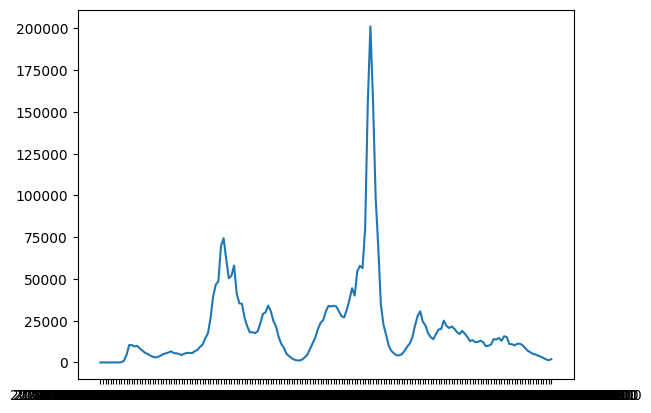

In [64]:
pa__covid = covid.loc[covid.state=="PA"]
print(pa__covid)

plt.plot(pa__covid.end_date, pa__covid.new_cases)

In [65]:
pa_flu = flu.loc[flu.location_name == "Pennsylvania"]
pa_flu


flu_and_covid = pa__covid.merge(pa_flu, left_on = ["end_of_weeks"], right_on = ["date"] )

In [66]:
flu_and_covid

,date_updated,state,start_date,end_date,tot_cases,new_cases,tot_deaths,new_deaths,new_historic_cases,new_historic_deaths,end_of_weeks,date,location,location_name,value,weekly_rate
0,2022-02-03T00:00:00.000,PA,2022-01-27T00:00:00.000,2022-02-02T00:00:00.000,2675788.0,68884.0,41136.0,1036.0,0,0,2022-02-05,2022-02-05,42,Pennsylvania,35.0,0.270027
1,2022-02-10T00:00:00.000,PA,2022-02-03T00:00:00.000,2022-02-09T00:00:00.000,2710244.0,34456.0,41957.0,821.0,0,0,2022-02-12,2022-02-12,42,Pennsylvania,50.0,0.385752
2,2022-02-17T00:00:00.000,PA,2022-02-10T00:00:00.000,2022-02-16T00:00:00.000,2732800.0,22556.0,42577.0,620.0,0,0,2022-02-19,2022-02-19,42,Pennsylvania,88.0,0.678924
3,2022-02-24T00:00:00.000,PA,2022-02-17T00:00:00.000,2022-02-23T00:00:00.000,2749362.0,16562.0,43018.0,441.0,0,0,2022-02-26,2022-02-26,42,Pennsylvania,77.0,0.594059
4,2022-03-03T00:00:00.000,PA,2022-02-24T00:00:00.000,2022-03-02T00:00:00.000,2759297.0,9935.0,43409.0,391.0,0,0,2022-03-05,2022-03-05,42,Pennsylvania,68.0,0.524623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,2023-04-13T00:00:00.000,PA,2023-04-06T00:00:00.000,2023-04-12T00:00:00.000,3551440.0,3473.0,50860.0,80.0,0,0,2023-04-15,2023-04-15,42,Pennsylvania,66.0,0.509193
63,2023-04-20T00:00:00.000,PA,2023-04-13T00:00:00.000,2023-04-19T00:00:00.000,3554128.0,2688.0,50946.0,86.0,0,0,2023-04-22,2023-04-22,42,Pennsylvania,82.0,0.632634
64,2023-04-27T00:00:00.000,PA,2023-04-20T00:00:00.000,2023-04-26T00:00:00.000,3556028.0,1900.0,50999.0,53.0,0,0,2023-04-29,2023-04-29,42,Pennsylvania,80.0,0.617204
65,2023-05-04T00:00:00.000,PA,2023-04-27T00:00:00.000,2023-05-03T00:00:00.000,3557354.0,1326.0,51042.0,43.0,0,0,2023-05-06,2023-05-06,42,Pennsylvania,47.0,0.362607


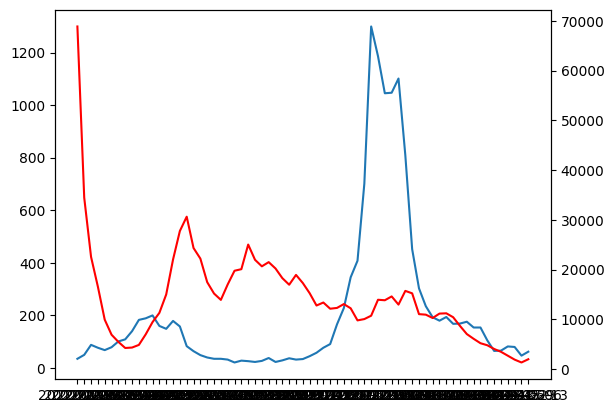

In [72]:
plt.plot(flu_and_covid["end_of_weeks"], flu_and_covid["value"])

twin = plt.twinx()
twin.plot(flu_and_covid["end_of_weeks"], flu_and_covid["new_cases"], color="red")

plt.show()

In [62]:
pa__covid.end_of_weeks.values[:200]

array(['2020-01-22', '2020-01-29', '2020-02-05', '2020-02-12',
       '2020-02-19', '2020-02-26', '2020-03-04', '2020-03-11',
       '2020-03-18', '2020-03-25', '2020-04-01', '2020-04-08',
       '2020-04-15', '2020-04-22', '2020-04-29', '2020-05-06',
       '2020-05-13', '2020-05-20', '2020-05-27', '2020-06-03',
       '2020-06-10', '2020-06-17', '2020-06-24', '2020-07-01',
       '2020-07-08', '2020-07-15', '2020-07-22', '2020-07-29',
       '2020-08-05', '2020-08-12', '2020-08-19', '2020-08-26',
       '2020-09-02', '2020-09-09', '2020-09-16', '2020-09-23',
       '2020-09-30', '2020-10-07', '2020-10-14', '2020-10-21',
       '2020-10-28', '2020-11-04', '2020-11-11', '2020-11-18',
       '2020-11-25', '2020-12-02', '2020-12-09', '2020-12-16',
       '2020-12-23', '2020-12-30', '2021-01-06', '2021-01-13',
       '2021-01-20', '2021-01-27', '2021-02-03', '2021-02-10',
       '2021-02-17', '2021-02-24', '2021-03-03', '2021-03-10',
       '2021-03-17', '2021-03-24', '2021-03-31', '2021-